If you were to pick the three most ridiculous fads of 2017, they would definitely be fidget spinners (are they still cool? Do kids still use that word "cool"?), artificial intelligence and, yes, cryptocurrencies. Joking aside, I'm actually impressed by the underlying concept and I'm quite bullish on the long term prospects of this disruptive technology. But enough about fidget spinners!!! I'm actually not a hodler of any cryptos. So, while I may not have a ticket to the moon, I can at least get on board the hype train by successfully predicting the price of cryptos by harnessing deep learning, machine learning and artificial intelligence (yes, all of them!).

I thought this was a completely unique concept to combine deep learning and cryptos (blog-wise at least), but in researching this post (i.e. looking for code to copy+paste), I came across [something quite similar](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price). That post only touched on Bitcoin (the most famous crypto of them all), but I'll also discuss Ethereum (commonly known as ether, eth or lambo-money). And since Ether is clearly superior to Bitcoin ([have you not heard of Metropolis?](https://ethereumprice.org/ground-breaking-metropolis-release-flying-radar/)), this post will definitely be better than that other one (though [this project](https://github.com/llens/CryptoCurrencyTrader) includes Ether).

We're going to employ a Long Short Term Memory (LSTM) model; it's a particular type of deep learning model that is well suited to time series data (or any data with temporal/spatial/structural order e.g. movies, sentences, etc.). If you wish to truly understand the underlying theory (what kind of crypto enthusiast are you?), then I'd recommend [this blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) or [this blog](http://blog.echen.me/2017/05/30/exploring-lstms/) or the [original (white)paper](http://www.bioinf.jku.at/publications/older/2604.pdf). As I'm shamelessly trying to appeal to a wider non-machine learning audience, I'll keep the code to a minimum. There's a Jupyter (Python) notebook available [here](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb), if you want to play around with the data or build your own models. Let's get started!

### Data

Before we build the model, we need to obtain some data for it. There's a [dataset on Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data) that details minute by minute Bitcoin prices (plus some other factors) for the last few years (featured on that [other blog post](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price)). Over this timescale, noise could overwhelm the signal, so we'll opt for daily prices. The issue here is that we may have not sufficient data (we'll have hundreds of rows rather than thousands or millions). In deep learning, no model can overcome a severe lack of data. I also don't want to rely on static files, as that'll complicate the process of updating the model in the future with new data. Instead, we'll aim to pull data from websites and APIs.

As we'll be combining multiple cryptos in one model, it's probably a good idea to pull the data from one source. We'll use [coinmarketcap.com](https://coinmarketcap.com). For now, we'll only consider Bitcoin and Ether, but it wouldn't be hard to add the [latest overhyped altcoin](https://coinmarketcap.com/currencies/iota/) using this approach. Before we import the data, we must load some python packages that will make our lives so much easier.

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2017-11-23,8232.38,8267.40,8038.77,8038.77,4225180000,137444000000
1,2017-11-22,8077.95,8302.26,8075.47,8253.55,3633530000,134851000000
2,2017-11-21,8205.74,8348.66,7762.71,8071.26,4277610000,136967000000
3,2017-11-20,8039.07,8336.86,7949.36,8200.64,3488450000,134167000000
4,2017-11-19,7766.03,8101.91,7694.10,8036.49,3149320000,129595000000


In [2]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2017-11-23,381.44,425.55,376.09,410.17,1845680000,36577300000
1,2017-11-22,360.31,381.42,360.15,380.65,800819000,34544000000
2,2017-11-21,367.44,372.47,350.69,360.40,949912000,35220200000
3,2017-11-20,354.09,372.14,353.29,366.73,807027000,33933400000
4,2017-11-19,347.40,371.29,344.74,354.39,1181530000,33284900000


To explain what's just happened, we've loaded some python packages and then imported the table that you see on [this site](https://coinmarketcap.com/currencies/bitcoin/historical-data/). With a little bit of data cleaning, we arrive at the above table. We also do the same thing for ether by simply replacing 'bitcoin' with 'ethereum' in the url (code omitted).

To prove that the data is accurate, we can plot the price and volume of both cryptos over time.

In [3]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)

In [4]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

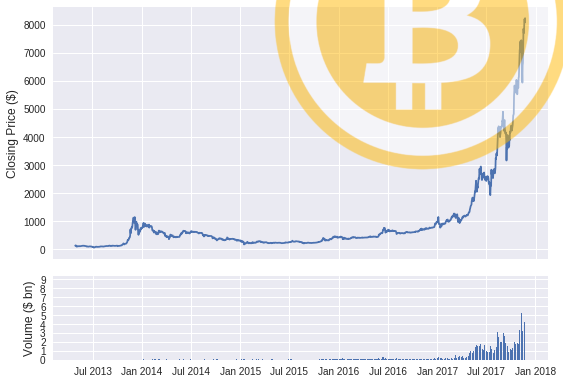

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
fig.figimage(bitcoin_im, 100, 120, zorder=3,alpha=.5)
plt.show()

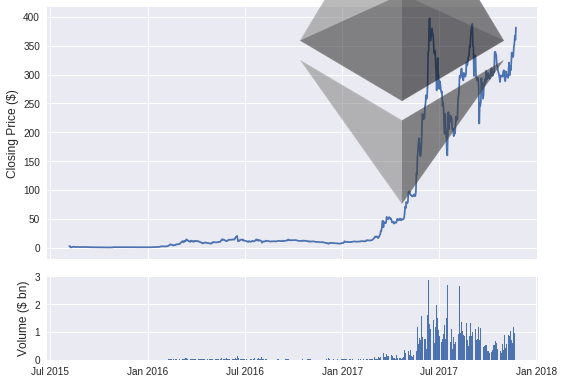

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 300, 180, zorder=3, alpha=.6)
plt.show()

In [7]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2017-11-23,8232.38,8267.40,8038.77,8038.77,4225180000,137444000000,381.44,425.55,376.09,410.17,1845680000,36577300000,-0.023518,0.075320
1,2017-11-22,8077.95,8302.26,8075.47,8253.55,3633530000,134851000000,360.31,381.42,360.15,380.65,800819000,34544000000,0.021738,0.056451
2,2017-11-21,8205.74,8348.66,7762.71,8071.26,4277610000,136967000000,367.44,372.47,350.69,360.40,949912000,35220200000,-0.016389,-0.019160
3,2017-11-20,8039.07,8336.86,7949.36,8200.64,3488450000,134167000000,354.09,372.14,353.29,366.73,807027000,33933400000,0.020098,0.035697
4,2017-11-19,7766.03,8101.91,7694.10,8036.49,3149320000,129595000000,347.40,371.29,344.74,354.39,1181530000,33284900000,0.034826,0.020121


### Training, Test & Random Walks

We have some data, so now we need to build a model. In deep learning, the data is typically split into training and test sets. The model is built on the training set and subsequently evaluated on the unseen test set. In time series models, we generally train on one period of time and then test on another separate period. Rather arbitrarily, I'll set the cut-off date to June 1st 2017 (i.e. model will be trained on data before that date and assessed on data after it).

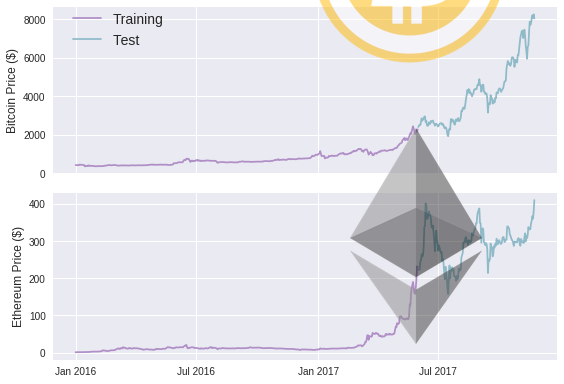

In [8]:
split_date = '2017-06-01'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             200, 260, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             350, 40, zorder=3,alpha=.5)
plt.show()

You can see that the training period mostly consists of periods when cryptos were relatively cheaper. As such, the training data may not be representative of the test data, undermining the model's ability to generalise to unseen data (you could try to make your data stationary- discussed [here](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/)). But why let negative realities get in the way of baseless optimism? Before we take our deep artificially intelligent machine learning model to the moon, it's worth discussing a simpler model. The most basic model is to set tomorrow's price equal to today's price (which we'll crudely call a lag model). This is how we'd define such a model in mathematical terms:

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1}
\end{align}

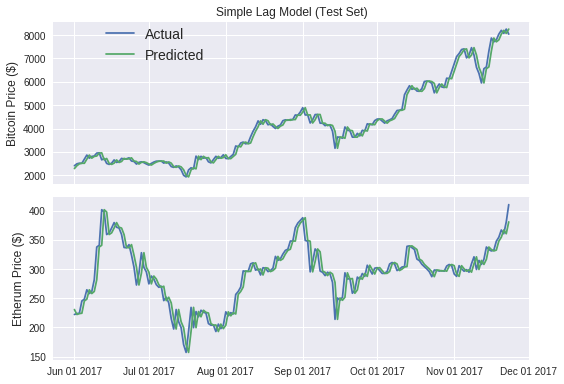

In [9]:
# trivial lag model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

Extending this trivial lag model, [stock prices are commonly treated as random walks](https://www.tcd.ie/Economics/assets/pdf/SER/2007/Samuel_Dupernex.pdf), which can be defined in these mathematical terms:

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)
\end{align}

We'll determine &mu; and &sigma; from the training sets and apply the random walk model to the Bitcoin and Ethereum test sets.

First, we may want to make sure the daily change in price follows a normal distribution. We'll plot the histogram of values.

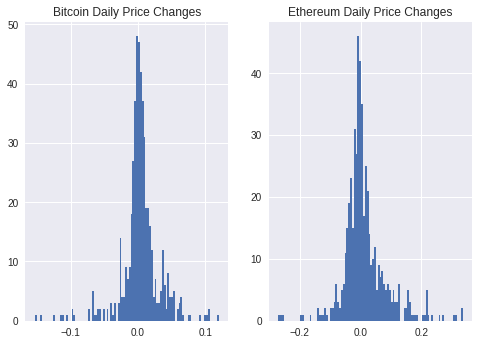

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

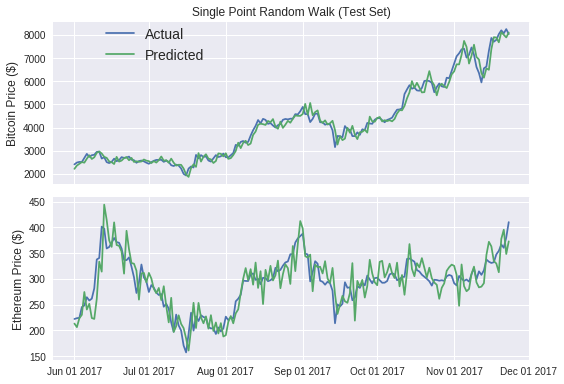

In [11]:
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['bt_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['eth_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close'].values[1:] * 
     (1+bt_random_steps), label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
     (1+eth_random_steps), label='Predicted')
ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

Wow! Look at those prediction lines. Apart from a few kinks, it broadly tracks the actual closing price for each coin. It even captures the eth rises (and subsequent falls) in mid-June and late August. At this stage, if I was to announce the launch of sheehanCoin, I'm sure that ICO would stupidly over-subscribed. As pointed out on that other blog, models that only make predictions one point into the future are often misleadingly accurate, as errors aren't carried over to subsequent predictions. No matter how large the error, it's essentially reset at each time point, as the model is fed the true price. The Bitcoin random walk is particularly deceptive, as the scale of the y-axis is quite wide, making the prediction line appear quite smooth.

Single point predictions are unfortunately quite common when evaluating time series models (e.g.[here](https://medium.com/@binsumi/neural-networks-and-bitcoin-d452bfd7757e) and [here](https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f)). A better idea could be to measure its accuracy on multi-point predictions. That way, errors from previous predictions aren't reset but rather are compounded by subsequent predictions. Thus, poor models are penalised more heavily. In mathematical terms:

\begin{align}
PredPrice_{t} & = PredPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)\ \&  \ PredPrice_0 = Price_0
\end{align}

Let's get our random walk model to predict the closing prices over the total test set.

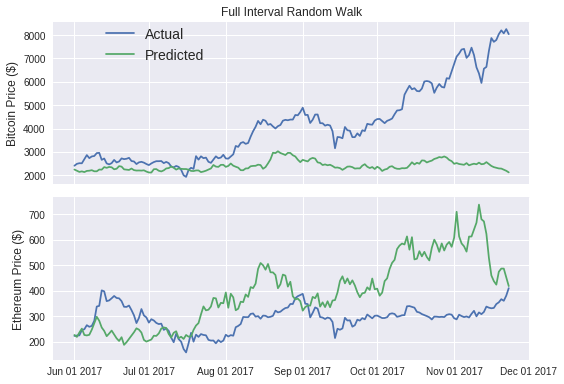

In [12]:
bt_random_walk = []
eth_random_walk = []
for n_step, (bt_step, eth_step) in enumerate(zip(bt_random_steps, eth_random_steps)):
    if n_step==0:
        bt_random_walk.append(market_info[market_info['Date']< split_date]['bt_Close'].values[0] * (bt_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (eth_step+1))
    else:
        bt_random_walk.append(bt_random_walk[n_step-1] * (bt_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         bt_random_walk[::-1], label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         eth_random_walk[::-1], label='Predicted')

ax1.set_title('Full Interval Random Walk')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

The model predictions are extremely sensitive to the random seed. I've selected one where the full interval random walk looks almost decent for Ethereum. In the [accompanying Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb), you can interactively play around with the seed value below to see how badly it can perform.

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_func(freq):
    np.random.seed(freq)
    random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
    random_walk = []
    for n_step,i in enumerate(random_steps):
        if n_step==0:
            random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (i+1))
        else:
            random_walk.append(random_walk[n_step-1] * (i+1))
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
    ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps), label='Predicted')
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps))
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
             random_walk[::-1])
    ax1.set_title('Single Point Random Walk')
    ax1.set_ylabel('')
    # for static figures, you may wish to insert the random seed value
#    ax1.annotate('Random Seed: %d'%freq, xy=(0.75, 0.2),  xycoords='axes fraction',
#            xytext=(0.75, 0.2), textcoords='axes fraction')
    ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
    ax2.set_title('Full Interval Random Walk')
    fig.text(0.0, 0.5, 'Ethereum Price ($)', va='center', rotation='vertical',fontsize=12)
    plt.tight_layout()
#    plt.savefig('image%d.png'%freq, bbox_inches='tight')
    plt.show()
    
interact(plot_func, freq =widgets.IntSlider(min=200,max=210,step=1,value=205, description='Random Seed:'))

<function __main__.plot_func>

Notice how the single point random walk always looks quite accurate, even though there's no real substance behind it. Hopefully, you'll be more suspicious of any blog that claims to accurately predict prices. I probably shouldn't worry; it's not like crypto fans to be seduced by [slick marketing claims](https://uetoken.com/).

## Long Short Term Memory (LSTM)

Like I said, if you're interested in the theory behind LSTMs, then I'll refer you to [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [this](http://blog.echen.me/2017/05/30/exploring-lstms/) and [this](http://www.bioinf.jku.at/publications/older/2604.pdf). Luckily, we don't need to build the network from scratch (or even understand it), there exists packages that include standard implementations of various deep learning algorithms (e.g. [TensorFlow](https://www.tensorflow.org/get_started/get_started), [Keras](https://keras.io/#keras-the-python-deep-learning-library), [PyTorch](http://pytorch.org/), etc.). I'll opt for Keras, as I find it the most intuitive for non-experts. If you're not familiar with Keras, then check out my [previous tutorial](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network-beginners/).

In [14]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [15]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
692,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
691,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
690,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
689,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
688,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


I've created a new data frame called `model_data`. I've removed some of the previous columns (open price, daily highs and lows) and reformulated some new ones. `close_off_high` represents the gap between the closing price and price high for that day, where values of -1 and 1 mean the closing price was equal to the daily low or daily high, respectively. The `volatility` columns are simply the difference between high and low price divided by the opening price. You may also notice that `model_data` is arranged in order of earliest to latest. We don't actually need the date column anymore, as that information won't be fed into the model.

Our LSTM model will use previous data (both bitcoin and eth) to predict the next day's closing price of a specific coin. We must decide how many previous days it will have access to. Again, it's rather arbitrary, but I'll opt for 10 days, as it's a nice round number. We build little data frames consisting of 10 consecutive days of data (called windows), so the first window will consist of the 0-9th rows of the training set (Python is zero-indexed), the second will be the rows 1-10, etc.  Picking a small window size means we can feed more windows into our model; the downside is that the model may not have sufficient information to detect complex long term behaviours (if such things exist). 

Deep learning models don't like inputs that vary wildly. Looking at those columns, some values range between -1 and 1, while others are on the scale of millions. We need to normalise the data, so that our inputs are somewhat consistent. Typically, you want values between -1 and 1. The `off_high` and `volatility` columns are fine as they are. For the remaining columns, like that [other blog post](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price), we'll normalise the inputs to the first value in the window.

In [18]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [19]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [31]:
training_set.head()

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
692,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
691,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
690,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
689,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
688,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [23]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [24]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

In [35]:
LSTM_training_inputs[3]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
689,0.000000,0.000000,-0.474265,0.012649,0.000000,0.000000,-0.057657,0.047943
688,-0.002609,-0.102785,-0.013333,0.010391,-0.004509,-0.365094,0.697930,0.025236
687,-0.009190,-0.115262,-0.003623,0.012782,-0.003793,-0.108172,-0.214540,0.026263
686,0.057632,1.275673,-0.951499,0.069045,-0.013070,0.869953,0.681644,0.040587
685,0.046503,0.481203,0.294196,0.032762,0.033850,0.575763,-0.806717,0.055274
684,0.033527,-0.161120,0.814194,0.017094,0.033896,-0.346471,-0.411897,0.019021
683,0.034404,-0.064495,-0.919598,0.017758,0.046885,0.128935,-0.938235,0.025266
682,0.035420,0.051264,-0.344118,0.015155,0.110552,1.922555,-0.717450,0.070840
681,0.006003,2.004535,1.000000,0.027868,0.194368,7.371991,0.217391,0.214953
680,-0.001662,3.519213,-0.475349,0.024731,0.183891,1.905197,-0.428571,0.061404


This table represents an example of our LSTM model input (we'll actually have hundreds of similar tables). We've normalised some columns so that their values are equal to 0 in the first time point, so we're aiming to predict changes in price relative to this timepoint. We're now ready to build the LSTM model. This is actually quite straightforward with Keras, you simply stack componenets on top of each other (better explained [here](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network-beginners/)).

In [37]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [41]:
LSTM_test_outputs.shape

(166,)

In [43]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


So, the `build_model` functions constructs an empty model unimaginatively called model (`model = Sequential`), to which an LSTM layer is added. That layer has been shaped to fit our inputs (n x m tables, where n and m represent the number of timepoints/rows and columns, respectively). The function also includes more generic neural network features, like [dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) and [activation functions](https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/). Now, we just need to specify the number of neurons to place in the LSTM layer (I've opted for 20 to keep runtime reasonable), as well as the data on which the model will be trained.

In [44]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
3s - loss: 0.1650
Epoch 2/50
3s - loss: 0.1128
Epoch 3/50
2s - loss: 0.1060
Epoch 4/50
2s - loss: 0.0950
Epoch 5/50
2s - loss: 0.0857
Epoch 6/50
2s - loss: 0.0832
Epoch 7/50
2s - loss: 0.0818
Epoch 8/50
2s - loss: 0.0809
Epoch 9/50
2s - loss: 0.0793
Epoch 10/50
2s - loss: 0.0789
Epoch 11/50
2s - loss: 0.0746
Epoch 12/50
2s - loss: 0.0754
Epoch 13/50
2s - loss: 0.0735
Epoch 14/50
2s - loss: 0.0697
Epoch 15/50
2s - loss: 0.0678
Epoch 16/50
2s - loss: 0.0683
Epoch 17/50
2s - loss: 0.0743
Epoch 18/50
2s - loss: 0.0689
Epoch 19/50
2s - loss: 0.0699
Epoch 20/50
2s - loss: 0.0695
Epoch 21/50
2s - loss: 0.0685
Epoch 22/50
2s - loss: 0.0701
Epoch 23/50
2s - loss: 0.0676
Epoch 24/50
2s - loss: 0.0666
Epoch 25/50
2s - loss: 0.0688
Epoch 26/50
2s - loss: 0.0654
Epoch 27/50
2s - loss: 0.0659
Epoch 28/50
2s - loss: 0.0645
Epoch 29/50
2s - loss: 0.0689
Epoch 30/50
2s - loss: 0.0686
Epoch 31/50
2s - loss: 0.0665
Epoch 32/50
2s - loss: 0.0689
Epoch 33/50
2s - loss: 0.0691
Epoch 34/50
2s - lo

If everything went to plan, then we'd expect the training error to have gradually decreased over time.

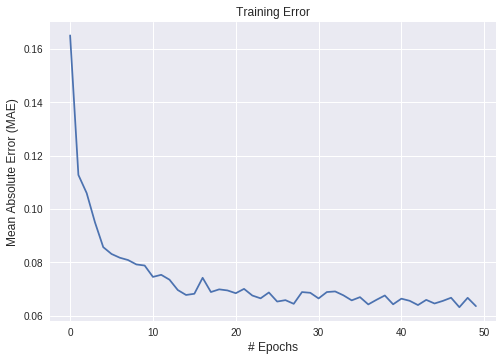

In [45]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

We've just built an LSTM model to predict tomorrow's Ethereum closing price. Let's see how well it performs. We start by examining its performance on the training set (data before June 2017). That number below the code represents the model's mean absolute error (mae) on the training set after the 50th training iteration (or epoch). Instead of relative changes, we can view the model output as daily closing prices.

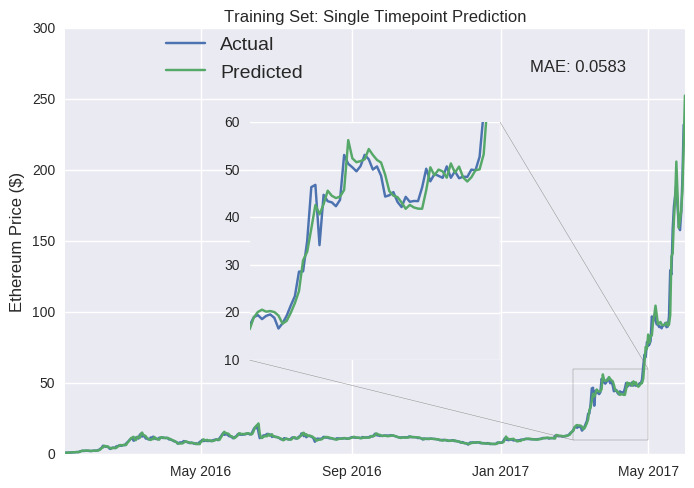

In [27]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

We shouldn't be too surprised by its apparent accuracy here. The model could access the source of its error and adjust itself accordingly. In fact, it's not hard to attain almost zero training errors. We could just cram in hundreds of neurons and train for thousands of epochs (a process known as overfitting, where you're essentially predicting noise- I included the `Dropout()` call in the `build_model` function to mitigate this risk for our relatively small model). We should be more interested in its performance on the test dataset, as this represents completely new data for the model.

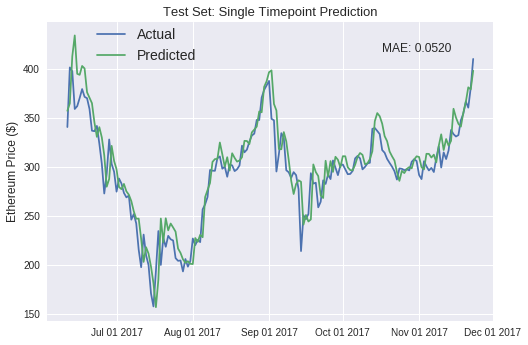

In [46]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

Caveats aside about the misleading nature of single point predictions, our LSTM model *seems* to have performed well on the unseen test set. The most obvious flaw is that it fails to detect the inevitable downturn when the eth price suddenly shoots up (e.g mid-June and October). In fact, this is a persistent failure; it's just more apparent at these spikes. The predicted price regularly seems equivalent to the actual price just shifted one day later (e.g. the drop in mid-July). Furthermore, the model seems to be systemically overestimating the future value of Ether (join the club, right?), as the predicted line near always runs higher than the actual line. I suspect this is because the training data represents a period during which the price of Ether rose astronomically, so it expects that trend to continue (don't we all). We can also build a similar LSTM model for Bitcoin- test set predictions are plotted below (see [Jupyter notebook for full code](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb)).

In [47]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
2s - loss: 0.1009
Epoch 2/50
2s - loss: 0.0647
Epoch 3/50
2s - loss: 0.0457
Epoch 4/50
2s - loss: 0.0425
Epoch 5/50
2s - loss: 0.0363
Epoch 6/50
2s - loss: 0.0330
Epoch 7/50
2s - loss: 0.0310
Epoch 8/50
2s - loss: 0.0317
Epoch 9/50
2s - loss: 0.0314
Epoch 10/50
2s - loss: 0.0298
Epoch 11/50
2s - loss: 0.0267
Epoch 12/50
2s - loss: 0.0288
Epoch 13/50
2s - loss: 0.0272
Epoch 14/50
2s - loss: 0.0276
Epoch 15/50
2s - loss: 0.0275
Epoch 16/50
2s - loss: 0.0273
Epoch 17/50
2s - loss: 0.0259
Epoch 18/50
2s - loss: 0.0262
Epoch 19/50
2s - loss: 0.0254
Epoch 20/50
2s - loss: 0.0268
Epoch 21/50
2s - loss: 0.0248
Epoch 22/50
2s - loss: 0.0242
Epoch 23/50
2s - loss: 0.0245
Epoch 24/50
2s - loss: 0.0263
Epoch 25/50
2s - loss: 0.0237
Epoch 26/50
2s - loss: 0.0255
Epoch 27/50
2s - loss: 0.0244
Epoch 28/50
2s - loss: 0.0241
Epoch 29/50
2s - loss: 0.0244
Epoch 30/50
2s - loss: 0.0244
Epoch 31/50
2s - loss: 0.0245
Epoch 32/50
2s - loss: 0.0230
Epoch 33/50
2s - loss: 0.0233
Epoch 34/50
2s - lo

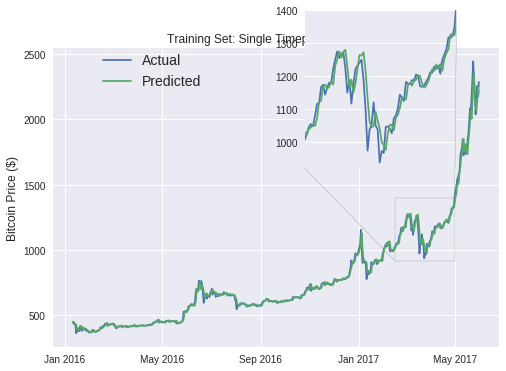

In [48]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

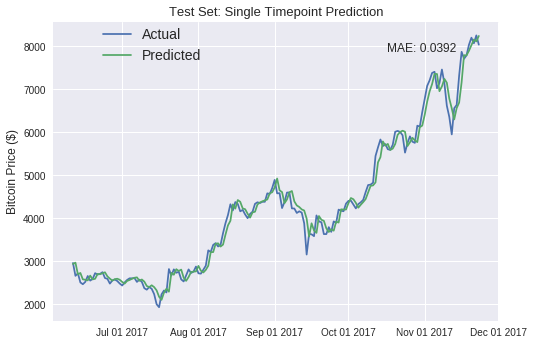

In [49]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

As I've stated earlier, single point predictions can be deceptive. Looking more closely, you'll notice that, again, the predicted values regularly mirror the previous values (e.g. October). Our fancy deep learning LSTM model has partially reproducted a [autregressive (AR) model](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/) of some order `p`, where future values are simply the weighted sum of the previous `p` values. We can define an AR model in these mathematical terms:  

\begin{align}
PredPrice_{t} & = \phi_0 + \phi_1*Price_{t-1} + \ldots + \phi_p*Price_{t-p} + \epsilon_t, \ \epsilon_t \sim N(0, \sigma)\
\end{align}

The good news is that AR models are commonly employed in time series tasks (e.g. [stock market prices](https://upcommons.upc.edu/bitstream/handle/2099/3572/04marcek.pdf)), so the LSTM model appears to have landed on a sensible solution. The bad news is that it's a waste of the LSTM capabilities, we could have a built a much simpler AR model in much less time and probably achieved similar results (though the title of this post would have been much less clickbaity). [More complex does not automatically equal more accurate](https://pdfs.semanticscholar.org/696c/2fa5697f58914921ff37d69ced44ddea143f.pdf)). 

We'll now build LSTM models to predict crypto prices for the next 5 days.

In [50]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                  training_set['eth_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
2s - loss: 0.2212
Epoch 2/50
2s - loss: 0.1578
Epoch 3/50
2s - loss: 0.1443
Epoch 4/50
2s - loss: 0.1381
Epoch 5/50
2s - loss: 0.1282
Epoch 6/50
2s - loss: 0.1258
Epoch 7/50
2s - loss: 0.1239
Epoch 8/50
2s - loss: 0.1268
Epoch 9/50
2s - loss: 0.1200
Epoch 10/50
2s - loss: 0.1202
Epoch 11/50
2s - loss: 0.1171
Epoch 12/50
2s - loss: 0.1197
Epoch 13/50
2s - loss: 0.1161
Epoch 14/50
2s - loss: 0.1176
Epoch 15/50
2s - loss: 0.1172
Epoch 16/50
2s - loss: 0.1199
Epoch 17/50
2s - loss: 0.1152
Epoch 18/50
2s - loss: 0.1171
Epoch 19/50
2s - loss: 0.1163
Epoch 20/50
2s - loss: 0.1145
Epoch 21/50
2s - loss: 0.1138
Epoch 22/50
2s - loss: 0.1121
Epoch 23/50
2s - loss: 0.1125
Epoch 24/50
2s - loss: 0.1108
Epoch 25/50
2s - loss: 0.1143
Epoch 26/50
2s - loss: 0.1106
Epoch 27/50
2s - loss: 0.1124
Epoch 28/50
2s - loss: 0.1110
Epoch 29/50
2s - loss: 0.1126
Epoch 30/50
2s - loss: 0.1108
Epoch 31/50
2s - loss: 0.1114
Epoch 32/50
2s - loss: 0.1104
Epoch 33/50
2s - loss: 0.1089
Epoch 34/50
2s - lo

In [52]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
2s - loss: 0.1042
Epoch 2/50
2s - loss: 0.0645
Epoch 3/50
2s - loss: 0.0526
Epoch 4/50
2s - loss: 0.0480
Epoch 5/50
2s - loss: 0.0448
Epoch 6/50
2s - loss: 0.0435
Epoch 7/50
2s - loss: 0.0418
Epoch 8/50
2s - loss: 0.0406
Epoch 9/50
2s - loss: 0.0413
Epoch 10/50
2s - loss: 0.0410
Epoch 11/50
2s - loss: 0.0395
Epoch 12/50
2s - loss: 0.0393
Epoch 13/50
2s - loss: 0.0396
Epoch 14/50
2s - loss: 0.0391
Epoch 15/50
2s - loss: 0.0386
Epoch 16/50
2s - loss: 0.0396
Epoch 17/50
2s - loss: 0.0383
Epoch 18/50
2s - loss: 0.0381
Epoch 19/50
2s - loss: 0.0387
Epoch 20/50
2s - loss: 0.0383
Epoch 21/50
2s - loss: 0.0384
Epoch 22/50
2s - loss: 0.0380
Epoch 23/50
2s - loss: 0.0373
Epoch 24/50
2s - loss: 0.0365
Epoch 25/50
2s - loss: 0.0374
Epoch 26/50
2s - loss: 0.0377
Epoch 27/50
2s - loss: 0.0372
Epoch 28/50
2s - loss: 0.0371
Epoch 29/50
2s - loss: 0.0376
Epoch 30/50
2s - loss: 0.0357
Epoch 31/50
2s - loss: 0.0373
Epoch 32/50
2s - loss: 0.0357
Epoch 33/50
2s - loss: 0.0358
Epoch 34/50
2s - lo

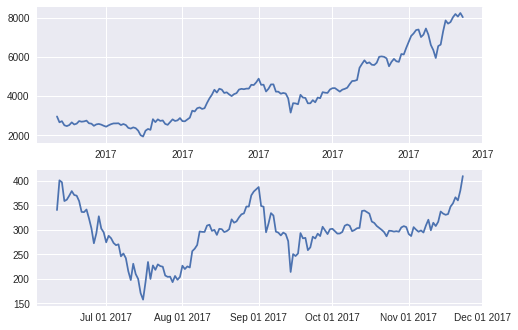

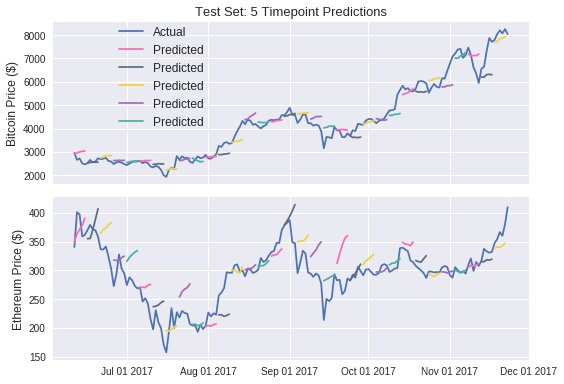

In [53]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
for i, (eth_pred, bt_pred) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

The predictions are visibly less impressive than their single point counterparts. Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

In [35]:
# warning: this cell may take some time to execute
# this code builds 25 LSTM models for eth and bitcoin each (with 25 different initialisations)
# the models are then saved so you hopefully only need to run this cell once

# random seed for reproducibility
# for rand_seed in range(775,800):
#     print(rand_seed)
#     np.random.seed(rand_seed)
#     temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
#     temp_model.fit(LSTM_training_inputs,
#                  (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1,
#                  epochs=50, batch_size=1, verbose=0, shuffle=True)
#     temp_model.save('eth_model_randseed_%d.h5'%rand_seed)
#     temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
#     temp_model.fit(LSTM_training_inputs,
#                  (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1,
#                  epochs=50, batch_size=1, verbose=0, shuffle=True)
#     temp_model.save('bt_model_randseed_%d.h5'%rand_seed)

In [36]:
# assuming the previous cell was completed, this cell loads in the different initialisations
# and calculates the average mean absolute error (mae)

from keras.models import load_model

eth_preds = []
bt_preds = []
for rand_seed in range(775,800):
    temp_model = load_model('eth_model_randseed_%d.h5'%rand_seed)
    eth_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['eth_Close'].values[window_len:]/test_set['eth_Close'].values[:-window_len]-1))))
    temp_model = load_model('bt_model_randseed_%d.h5'%rand_seed)
    bt_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['bt_Close'].values[window_len:]/test_set['bt_Close'].values[:-window_len]-1))))

In [39]:
eth_random_walk_preds = []
bt_random_walk_preds = []
for rand_seed in range(775,800):
    np.random.seed(rand_seed)
    eth_random_walk_preds.append(
        np.mean(np.abs((np.random.normal(eth_r_walk_mean, eth_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['eth_Close'][window_len:])/np.array(test_set['eth_Close'][:-window_len]))))
    bt_random_walk_preds.append(
    np.mean(np.abs((np.random.normal(bt_r_walk_mean, bt_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['bt_Close'][window_len:])/np.array(test_set['bt_Close'][:-window_len]))))

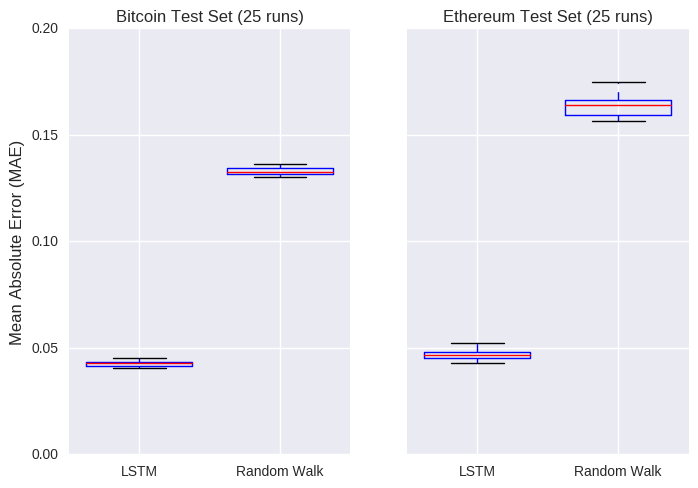

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.boxplot([bt_preds, bt_random_walk_preds],widths=0.75)
ax1.set_ylim([0, 0.2])
ax2.boxplot([eth_preds, eth_random_walk_preds],widths=0.75)
ax2.set_ylim([0, 0.2])
ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_xticklabels(['LSTM', 'Random Walk'])
ax1.set_title('Bitcoin Test Set (25 runs)')
ax2.set_title('Ethereum Test Set (25 runs)')
ax2.set_yticklabels('')
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
plt.show()

Maybe AI is worth the hype after all! Those graphs show the error on the test set after 25 different initialisations of each model. The LSTM model returns an average error of about 0.04 and 0.05 on the bitcoin and eth prices, respectively, crushing the corresponding random walk models.

Aiming to beat random walks is a pretty low bar. It would be more interesting to compare the LSTM model against more appropriate time series models (weighted average, autoregression, [ARIMA](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/) or Facebook's [Prophet algorithm](https://github.com/facebook/prophet)). On the other hand, I'm sure it wouldn't be hard to improve our LSTM model (gratuitously adding more layers and/or neurons, changing the batch size, learning rate, etc.). That said, hopefully you've detected my scepticism when it comes to applying deep learning to predict changes in crypto prices. That's because we're overlooking the best framework of all: human intelligence. Clearly, the perfect model* for predicting cryptos is:

\begin{align}
& Price^{Crypto}_{t} > Price^{Crypto}_{t-1} \,  \forall \ Crypto \neq OmiseGo \textrm{, }  \\
& \textrm{  where } Price^{Crypto}_{t} \to moon \textrm{, as } t \to    \infty           
\end{align}

&#42; This blog does not constitute financial advice and should not be taken as such. While cryptocurrency investments will definitely go up in value forever, they may also go down.

## Summary

We've collected some crypto data and fed it into a supercool deeply intelligent machine learning LSTM model. Unfortunately, its predictions were not that different from just spitting out the previous value. How can we make the model learn more sophisticated behaviours?

* **Change Loss Function**: MAE doesn't really encourage risk taking. For example, under mean squared error (MSE), the LSTM model would be forced to place more importance on detecting spikes/troughs. [More bespoke trading focused loss functions](http://www.faculty.ucr.edu/~taelee/paper/lossfunctions.pdf) could also move the model towards less conservative behaviours.

* **Penalise conservative AR-type models**: This would incentivise the deep learning algorithm to explore more risky/interesting models. Easier said than done!

* **Get more and/or better data**: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. This is probably the best and hardest solution.

If that's the positive spin, then the negative reality is that it's entirely possible that there is no detectable pattern to changes in crypto prices; that no model (however deep) can separate the signal from the noise (similar to the merits of using [deep learning to predict earthquakes](https://www.scientificamerican.com/article/can-artificial-intelligence-predict-earthquakes/)). And any pattern that does appear [can disappear as quickly](http://site.iugaza.edu.ps/wdaya/files/2013/03/A-Random-Walk-Down-Wall-Street.pdf) (see [efficient market hypothesis](results_merge.click2)). Just think how different Bitcoin in 2016 is to craze-riding Bitcoin of late 2017. Any model built on 2016 data would surely struggle to replicate these unprecedented movements. All of this suggests you might as well save yourself some time and stick to autoregression (unless you're writing a blog, of course).

But I'm sure they'll eventually find some use cases for deep learning. In the meantime, you can build your own LSTM model by downloading the Python code [here](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb). Thanks for reading!